# Calibration of NaI(Te) scintillator with two samples:
>    $^{22}$Na with 2 peaks and 2 visible Compton edges
>
>    $^{137}$Cs with one photo peak, compton edge and escape peak

In [3]:
# %load "../../style.py"
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit

sns.set(style='ticks', palette='Set2') 
sns.despine()

# These are the colors. Notice how this is programmed:
# You initialize your colors by 
# colorset = palette()
# then you can cycle through the colors:
# color = next(colorset)
# if you want your set to be reset, just create
# a new palette() instance! This way the colors do not interfere.

color_names = ['windows blue', "pale red", "faded green", "amber", 
          'dark green', 'dark fuchsia', 'browny orange', 
          'puke green', 'dark royal blue', 'dusty purple', 'red orange']
colors = sns.xkcd_palette(color_names)
palette = lambda: itertools.cycle(sns.xkcd_palette(color_names) )

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['legend.markerscale'] = 4
rcParams['axes.titlesize'] = fontsize_labels
rcParams['text.color'] = "0.3"
rcParams['xtick.color'] = "0.3"
rcParams['ytick.color'] = "0.3"
rcParams['axes.labelcolor'] = "0.3"
rcParams['axes.edgecolor'] = "0.8"

xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  

save_fig = True
if not save_fig:
        rcParams['figure.figsize'] = (13, 8) 
fig_dir = "./figures/"  # directory of figures

def fixticks(ax):    
    for t in ax.xaxis.get_ticklines(): t.set_color('0.8')
    for t in ax.yaxis.get_ticklines(): t.set_color('0.8')

In [146]:
# %load ../../preamb.py
import numpy as np
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter as sav
from scipy.special import erfc
from scipy.integrate import quad
import sys
import re

npy_dir = "./data_npy/"
data_dir = './data/'

In [5]:
# %load ../../tools.py
def uc_str(c, max_digit=4):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    as integers with max max_digit (=4) error digits
    as floats with max 4 error digits
    as exp else
    """
    digit = -int(np.floor(np.log10(c.s)))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < (max_digit + 1)): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

def enum(arr1, *args):
    i_range = range(len(arr1))
    return zip(i_range, arr1 ,*args)


In [103]:
def gauss(x, *p):
    A, mu, sigma, offset = p
    return  A * np.exp(-(x - mu)**2 / (2. * sigma**2)) + offset

def gauss_plus_exp(x, *p):
    A, mu, sigma, C, lamb = p
    return  A * np.exp(-(x - mu)**2 / (2. * sigma**2))  + \
            C * np.exp(-lamb * x)

def conv_analytical(x, *p):
    '''
    analytical solution of convolution of step and gauss
    as a crude approximation of klein nishima
    '''
    A_edge, x_step, sigma, offset = p
    return A_edge / 2 * erfc((x - x_step) / (np.sqrt(2) * sigma))  + offset

def peak_and_edge(x, *p):
    '''
    combines gauss peak and analytical solution to stepfunction convoluted with gauss
    '''
    A_peak, mu, sigma_peak, A_edge, x_max, sigma_edge, offset = p
    peak = A_peak * np.exp(-(x - mu)**2 / (2. * sigma_peak**2))
    edge = A_edge / 2 * erfc((x - x_max) / (np.sqrt(2) * sigma_edge))
    return(peak + edge + offset)

Background
----------------

In [94]:
#### Background ####
file_in = npy_dir + "na_background" + '.npy'
y_bg = np.load(file_in)
y_bg_e = un.uarray(y_bg, np.maximum(1, np.sqrt(y_bg)))

t_bg = 3600  # Real time
rate_bg = y_bg / t_bg
rate_bg_e = y_bg_e / t_bg

$^{137}$Cs Sample
-----------------

In [95]:
file_in = npy_dir + "na_137cs_01" + '.npy'
y = np.load(file_in)
x = np.arange(len(y))
y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))

t = 9742   
rate = y / t
rate = rate - rate_bg
rate[rate < 0] = 0
rate_e = y_e / t - rate_bg_e
rate_e[rate < 0] = 0 

y = rate
y_filtered = sav(y, 301, 4)
y_e = rate_e

print(t/3600)


2.706111111111111


### Fits:
* Photo peak: 662 keV
* Compton edge: 477 keV
* Escape peak: 183 keV

In [109]:
###### PHOTO PEAK #################
# Define range to be fitted
x_min = 6700    # lower bound
x_max = 10000    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit = x[mask]
y_fit = y[mask]
y_sigma = un.std_devs(y_e[mask])
# p0 is the initial guess for the fitting coefficients
# p = [A_peak, mu, sigma_peak, C_exp, lamb]
p0 = [0.7, 8000, 400, 0.05, 1/1000]
x_ref = 6500 # choose position x_ref = Point at which C_exp * e^(-lamb * (x - x_ref)) = 1 
p0[3] = p0[3] * np.exp(p0[4] * x_ref) # rescale to hight at position x_ref
coeff, var_matrix = curve_fit(gauss_plus_exp, x_fit, y_fit, p0=p0,
                              sigma=y_sigma, absolute_sigma=True)
cs_photo = uc.ufloat(coeff[1], var_matrix[1, 1])
fit_photo = gauss_plus_exp(x_fit, *coeff)

###### COMPTON EDGE  #################
# Define range to be fitted
x_min = 5000    # lower bound
x_max = 6500    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit2 = x[mask]
y_fit2 = y[mask]
y_sigma = (un.std_devs(y_e[mask]))
# p0 is the initial guess for the fitting coefficients
# p = [A_edge, x_step, sigma, offset]
p0 = [ 0.12,  5700,   330,   0.03]
coeff2, var_matrix2 = curve_fit(conv_analytical, x_fit2, y_fit2, p0=p0,
                                sigma=y_sigma, absolute_sigma=True)
cs_compton = uc.ufloat(coeff2[1], var_matrix2[1, 1])
fit_edge = conv_analytical(x_fit2, *coeff2)

###### ESCAPE PEAK #################
# Define range to be fitted
x_min = 1800    # lower bound
x_max = 3400    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit3 = x[mask]
y_fit3 = y[mask]
y_sigma = un.std_devs(y_e[mask])
# p0 is the initial guess for the fitting coefficients
# p = [A_peak, mu, sigma_peak, offset]
p0 = [0.02, 2300, 200, 0.16]
coeff3, var_matrix3 = curve_fit(gauss, x_fit3, y_fit3, p0=p0,  
                                sigma=y_sigma, absolute_sigma=True)
cs_escape = uc.ufloat(coeff3[1], var_matrix3[1, 1])
fit_escape = gauss(x_fit3, *coeff3)


randomtext='''
###### PEACE AND EDGE  #################
# Define range to be fitted
x_min = 4500    # lower bound
x_max = 10000    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit4 = x[mask]
y_fit4 = y[mask]
y_sigma = np.sqrt(un.std_devs(y_e[mask]))

# p0 is the initial guess for the fitting coefficients
# p = [A_peak, mu, sigma_peak, A_edge, x_step, sigma_edge, offset]
p0 = [0.7, 8000, 400, 0.12, 5700, 330, 0.03]
coeff4, var_matrix = curve_fit(peak_and_edge, x_fit4, y_fit4, p0=p0,  
                                sigma=y_sigma, absolute_sigma=True)
fit_photo_compton = peak_and_edge(x_fit4, *coeff4)

cs_photo = uc.ufloat(coeff4[1], var_matrix[1, 1])
cs_compton = uc.ufloat(coeff4[4], var_matrix[4, 4])
'''


## Plotting results

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


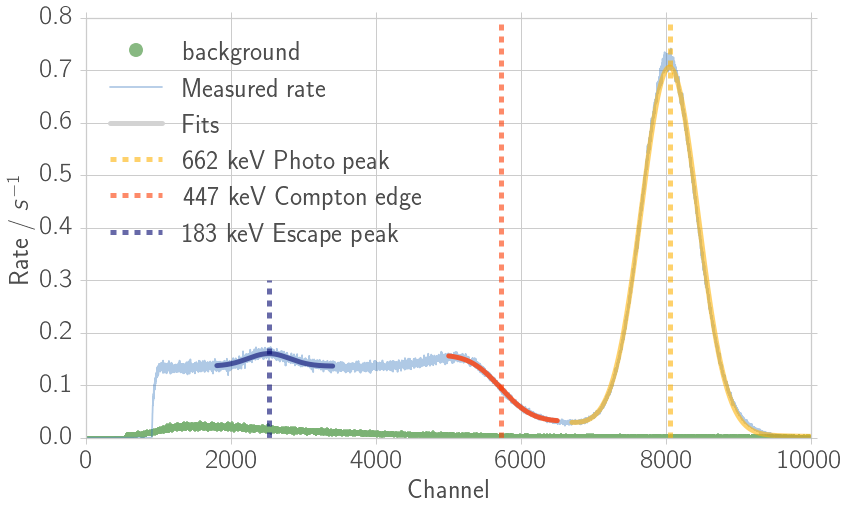

In [110]:
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)

sample_name = '$^{137}\mathrm{Cs}$'
if not save_fig:
    fig1.suptitle("Histogram NaI, Sample: " + sample_name)
ax1.plot(x, rate_bg, '.', alpha=0.9, label='background',color = colors[2])
ax1.plot(x, y, '-', alpha=0.4, label=('Measured rate'), color = colors[0])
#ax1.plot(x, y_filtered, '-', alpha=0.8, label=('Filtered rate'),c = colors[1])
ax1.plot(-1, -1, color='lightgray', linewidth=5,  label='Fits')

ax1.plot(x_fit, fit_photo, color=colors[3], linewidth=5,alpha=0.6)
ax1.plot([cs_photo.n] * 2, [0, 0.8], '--', color = colors[3], linewidth=5,alpha=0.6, 
         label='662 keV Photo peak')

ax1.plot(x_fit2, fit_edge, color = colors[-1], linewidth=5,alpha=0.8)
ax1.plot([cs_compton.n] * 2, [0, 0.8], '--', color = colors[-1], linewidth=5,alpha=0.6, 
         label='447 keV Compton edge')

ax1.plot(x_fit3, fit_escape, color = colors[8], linewidth=5,alpha=0.6)
ax1.plot([cs_escape.n] * 2, [0, 0.3], '--', color = colors[8], linewidth=5,alpha=0.6, 
         label='183 keV Escape peak')

#ax1.plot(x_fit4, fit_photo_compton, color=colors[3], linewidth=5,alpha=0.6, 
#         label='662 keV Photo peak \& \n 447 keV Compton edge')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr = 'Sample: ' + sample_name
#ax1.text(0.1, 0.95, textstr, transform=ax1.transAxes, va='top', bbox=props)
ax1.set_xlim(0, 10000)
ax1.set_ylim(0, 0.8)
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.legend(loc=2)
ax1.grid(True)

if save_fig:
    file_name = "histo_na_137cs"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")

$^{22}$Na Sample
----------------

### Fits:
* Photo peak 1: 511 keV
* Compton edge 1: 341 keV (hardly visible)
* Photo peak 2: 1277 keV
* Compton edge 2: 1064 keV


In [147]:
data_dir = './data/'

def get_rates(file_name):
    # get data
    file_in = npy_dir + file_name + '.npy'
    print(file_in)
    y = np.load(file_in)
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))      
    # get time
    file_in_mcd = data_dir + file_name + '.TKA'
    f = open(file_in_mcd)
    settings = f.readlines()
    f.close()
    t = np.float(settings[1])   # livetime is written in line 1...
    print('measurement time in h: ', t/3600)
    y_e = y_e / t      # counts to rates
    return  y_e

In [151]:
# Get data
file_in = "na_22na_02"
y_e = get_rates(file_in)

###### PEAK 1 #################
# Define range to be fitted
x_min = 5000    # lower bound
x_max = 8000    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit = x[mask]
y_fit = y[mask]
y_sigma = un.std_devs(y_e[mask])
# p0 is the initial guess for the fitting coefficients
# p = [A, mu, sigma, C, lamb, offset]
p0 = [0.03, 6200, 340, 0.003, 1/1000]
x_ref = x_min # choose position x_ref = Point at which C * e^(-lamb * (x - x_ref)) = 1 
p0[3] = p0[3] * np.exp(p0[4] * x_ref) # rescale to hight at position x_ref
coeff, var_matrix = curve_fit(gauss_plus_exp, x_fit, y_fit, p0=p0,
                              sigma=y_sigma, absolute_sigma=True)
na_photo1 = uc.ufloat(coeff[1], var_matrix[1, 1])
fit_peak1 = gauss_plus_exp(x_fit, *coeff)

###### PEAK 2 #################
# Define range to be fitted
x_min = 13000    # lower bound
x_max = 16000    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit2 = x[mask]
y_fit2 = y[mask]
y_sigma = un.std_devs(y_e[mask])
# p0 is the initial guess for the fitting coefficients
# p = [A, mu, sigma, offset]
p0 = [0.003, 14200, 400, 0.001, 1/1000]
x_ref = x_min # choose position x_ref = Point at which C * e^(-lamb * (x - x_ref)) = 1 
p0[3] = p0[3] * np.exp(p0[4] * x_ref) # rescale to hight at position x_ref
coeff2, var_matrix2 = curve_fit(gauss_plus_exp, x_fit2, y_fit2, p0=p0,
                              sigma=y_sigma, absolute_sigma=True)
na_photo2 = uc.ufloat(coeff2[1], var_matrix2[1, 1])
fit_peak2 = gauss_plus_exp(x_fit2, *coeff2)

###### COMPTON EDGE 1 #################
# Define range to be fitted
x_min = 3300    # lower bound
x_max = 5000    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit3 = x[mask]
y_fit3 = y[mask]
y_sigma = un.std_devs(y_e[mask])
# p0 is the initial guess for the fitting coefficients
# p = [A_edga, x_step, sigma, offset]
p0 = [0.01, 4000, 400, 1e-3]
fit_edge3 = conv_analytical(x_fit3, *p0)
coeff3, var_matrix3 = curve_fit(conv_analytical, x_fit3, y_fit3, p0=p0,
                              sigma=y_sigma, absolute_sigma=True)
na_compton1 = uc.ufloat(coeff3[1], var_matrix3[1, 1])
fit_edge1 = conv_analytical(x_fit3, *coeff3)

###### COMPTON EDGE 2 #################
# Define range to be fitted
x_min = 11290    # lower bound
x_max = 13150    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit4 = x[mask]
y_fit4 = y[mask]
y_sigma = un.std_devs(y_e[mask])
# p0 is the initial guess for the fitting coefficients
# p = [A_edga, x_step, sigma, offset]
p0 = [0.001, 12000, 400, 1e-3]
coeff4, var_matrix4 = curve_fit(conv_analytical, x_fit4, y_fit4, p0=p0,
                              sigma=y_sigma, absolute_sigma=True)
na_compton2 = uc.ufloat(coeff4[1], var_matrix4[1, 1])
fit_edge2 = conv_analytical(x_fit4, *coeff4)

peaks1 = [na_photo1, na_photo2, na_compton1, na_compton2]
[print(uc_str(i)) for i in peaks1]

./data_npy/na_22na_02.npy
measurement time in h:  1.1402777777777777
6349 \pm 2
14190 \pm 20
4300 \pm 900
(1.2 \pm 0.2)\mathrm{e}4


[None, None, None, None]

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


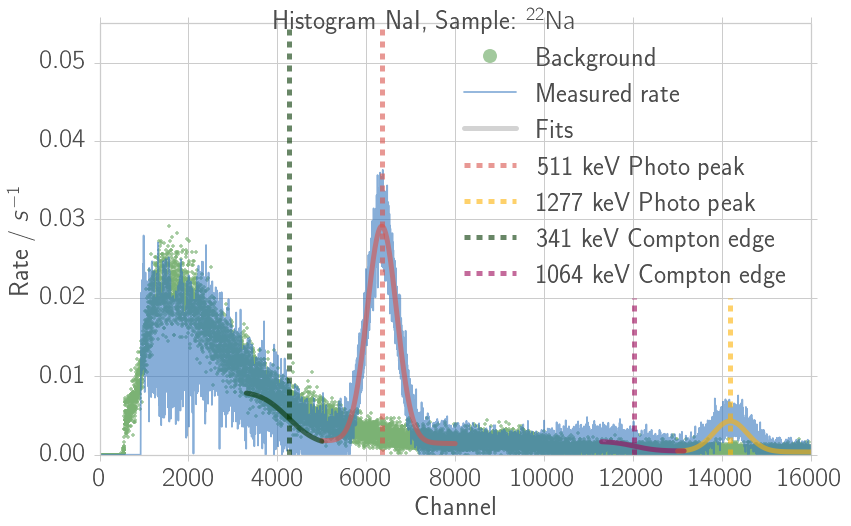

In [152]:
# Plotting
save_fig = False
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
sample_name = '$^{22}\mathrm{Na}$'
if not save_fig:
    fig1.suptitle("Histogram NaI, Sample: " + sample_name)

ax1.plot(x, rate_bg, '.', alpha=0.7, label='Background', color = colors[2])
ax1.plot(x, y, '-', alpha=0.6, label='Measured rate', color = colors[0])
#ax1.plot(x, y_fil, '-', alpha=1.0, c=counts.get_color(), label=('filtered data'))
ax1.plot(-1, -1, color='lightgray', linewidth=5,  label='Fits')

ax1.plot(x_fit, fit_peak1, color = colors[1], linewidth=5, alpha=0.6,)
ax1.plot([na_photo1.n] * 2, [0, 0.06], '--', color = colors[1], linewidth=5, alpha=0.6,
         label='511 keV Photo peak')

ax1.plot(x_fit2, fit_peak2, color=colors[3], linewidth=5, alpha=0.6)
ax1.plot([na_photo2.n] * 2, [0, 0.02], '--', color = colors[3], linewidth=5, alpha=0.6,
         label='1277 keV Photo peak')

ax1.plot(x_fit3, fit_edge1, color=colors[4], linewidth=5, alpha=0.6)
ax1.plot([na_compton1.n] * 2, [0, 0.06], '--', color = colors[4], linewidth=5,alpha=0.6,
         label='341 keV Compton edge')

ax1.plot(x_fit4, fit_edge2, color=colors[5], linewidth=5, alpha=0.6)
ax1.plot([na_compton2.n] * 2, [0, 0.02], '--', color = colors[5], linewidth=5,alpha=0.6,
         label='1064 keV Compton edge')


props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr = 'Sample: ' + sample_name
#ax1.text(0.1, 0.95, textstr, transform=ax1.transAxes, va='top', bbox=props)
ax1.set_xlim(0, 16000)
ax1.set_ylim(0, 0.055)
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.legend(loc="best")
ax1.grid(True)
#ax1.set_yscale("log")
if save_fig:
    file_name = "histo_na_22na"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


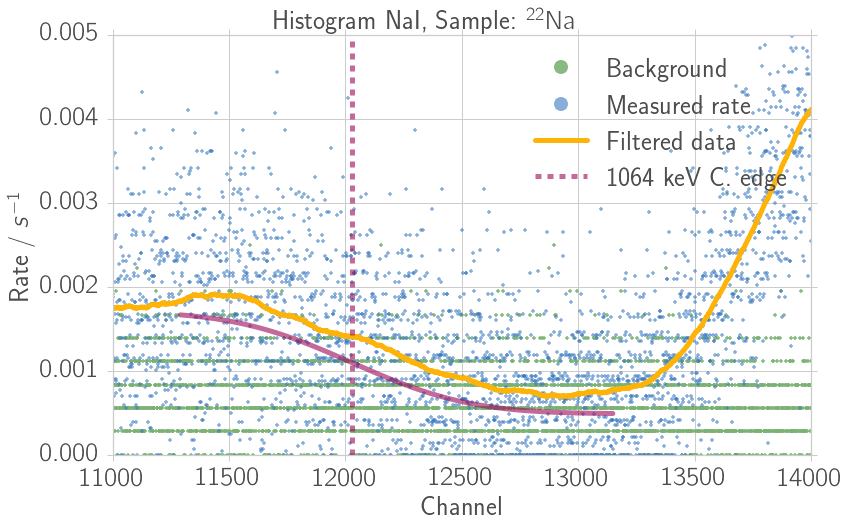

In [163]:
# Plotting
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
sample_name = '$^{22}\mathrm{Na}$'
if not save_fig:
    fig1.suptitle("Histogram NaI, Sample: " + sample_name)

ax1.plot(x, rate_bg, '.', alpha=0.9, label='Background', color = colors[2])
ax1.plot(x, y, '.', alpha=0.6, label='Measured rate', color = colors[0])

y_fil = sav(y, 1001, 4)
ax1.plot(x, y_fil, '-', alpha=1.0, color= colors[3], label='Filtered data', linewidth = 5)

ax1.plot(x_fit4, fit_edge2, color=colors[5], linewidth=5, alpha=0.6)
ax1.plot([na_compton2.n] * 2, [0, 0.02], '--', color = colors[5], linewidth=5,alpha=0.6,
         label='1064 keV C. edge')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr = 'Sample: ' + sample_name
#ax1.text(0.1, 0.95, textstr, transform=ax1.transAxes, va='top', bbox=props)
ax1.set_xlim(11000, 14000)
ax1.set_ylim(0, 0.005)
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.legend(loc=1)
ax1.grid(True)
#ax1.set_yscale("log")
if save_fig:
    file_name = "histo_na_22na2"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")

# Calibration by linear fitting
* Photo peak: 662 keV
* Compton edge: 477 keV
* Escape peak: 183 keV
* Photo peak 1: 511 keV
* Compton edge 1: 341 keV (hardly visible)
* Photo peak 2: 1277 keV
* Compton edge 2: 1064 keV

In [ ]:
energy = np.array([662, 477, 183, 511, 341, 1277, 1064])
fit_results = np.array([cs_photo, cs_compton, cs_escape, na_photo1, na_compton1, na_photo2, na_compton2])

channel = un.nominal_values(fit_results)
channel_error = un.std_devs(fit_results)
def linear(x, a, b):
    return (a*x + b)

coeff_lin, cov_lin = curve_fit(linear, energy[0:-1], channel[0:-1], p0=None, 
                               sigma=channel_error[0:-1], absolute_sigma=True)
c_lin = uc.correlated_values(coeff_lin, cov_lin)

chi_sq = (((linear(energy,*coeff_lin)-channel)/channel_error)**2).sum()/(len(energy)-3)

print(chi_sq)

# Switch to energy(channel) = A*channel + B:
d_lin = np.array([1 / c_lin[0], -c_lin[1] / c_lin[0]])
np.save(npy_dir + 'na_calibration', d_lin)

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


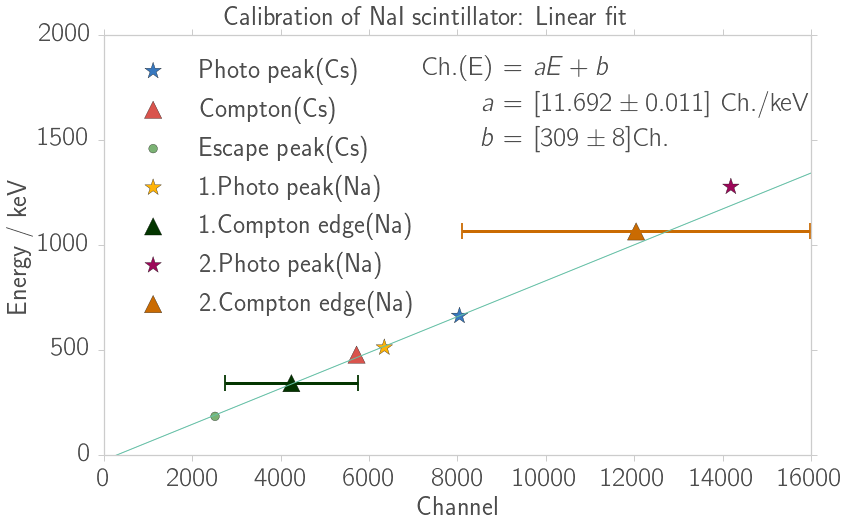

In [164]:
# Plotting
channel_min, channel_max = [0, 16000]
chs = np.linspace(channel_min, channel_max, 200)
fit = linear(chs, *d_lin)

fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle('Calibration of NaI scintillator: Linear fit')
ax1.fill_between(chs, 
        un.nominal_values(fit) + un.std_devs(fit),
        un.nominal_values(fit) - un.std_devs(fit),
        facecolor=colors[0], color=colors[0], alpha=0.2)
ax1.plot(chs, un.nominal_values(fit), '-', linewidth=1.0)  

labels = ["Photo peak(Cs)", "Compton(Cs)", "Escape peak(Cs)", "1.Photo peak(Na)", \
          "1.Compton edge(Na)", "2.Photo peak(Na)", "2.Compton edge(Na)"]
markers = ["*","^",".","*","^","*","^"]
for i in range(7):
    if channel_error[i]>1000:
        ax1.errorbar(channel[i], energy[i], xerr=channel_error[i], yerr=None, fmt=',',
             elinewidth=3.0, capsize=8.2, capthick=1.8,c = colors[i])
    ax1.scatter(channel[i], energy[i],c = colors[i], s= 300,label=labels[i],marker=markers[i])
ax1.legend(loc =2, markerscale=1)
ax1.set_xlim(channel_min, channel_max)
ax1.set_ylim(0,2000)
ax1.set_xlabel("Channel")
ax1.set_ylabel("Energy / keV")
#ax1.grid(True)

props = dict(boxstyle='round', facecolor='white', alpha=0.0)

textstr = "\\begin{eqnarray*} \
        \\ \\mathrm{Ch.(E)} &=& a E + b \\\\ \
        \\ a &=&[%s]\\ \\mathrm{Ch.}/\mathrm{keV} \\\\ \
        \\ b &=&[%s] \\mathrm{Ch.} \
        \end{eqnarray*}"%(uc_str(c_lin[0]),uc_str(c_lin[1]))
ax1.text(0.45, 0.95, textstr , transform=ax1.transAxes,
        verticalalignment='top', bbox=props)

#ax1.legend(loc=1)
if save_fig:
    file_name = "calibration_na_linear_fit"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


46.52800000000025